# Changelog

* Take open source code from https://github.com/juraam/stable-diffusion-from-scratch
* Remove usage of noise scheduler DDPM forward, sampling functions and use my own implementation
*

# Mathematical notations

- $t \in {0, 1, ..., T}$
- $x_t$: Noisy image at timestep $t$
- $x_0$: Predicted clean image (from noise prediction)
- $\alpha_t = 1 - \beta_t$: Noise strength
- $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$: Cumulative product of alphas (used for deriving noise level at timestep $t$)
- $\beta_t$: Variance schedule value at time $t$
- $\mu_t$: Mean of the Gaussian for sampling $x_{t-1}$
- $\sigma_t^2$: Variance of the reverse process at time $t$

## Forward diffusion

DDPM forward diffusion process:

$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

This exact formula is implemented exactly in the `forward` function in the DDPM class.

## Reverse diffusion

Equation 11 of the DDPM paper is the sampling / reverse diffusion:

$$
\mu_t(x_t, x_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_t
$$

And the posterior distribution:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_t(x_t, x_0), \sigma_t^2 \mathbf{I})
$$

## Training & Sampling

![](../notebook_imgs/training.png)
![](../notebook_imgs/sampling.png)

## Linear noise scheduler

$\alpha_t$ controls how much noise we add at timestep $t$.

$\beta_t$ controls the variance of the noise added at timestep $t$.

1) $\alpha_t = 1 - \beta_t$ the noise strength changes at each timestep $t$ (depends on $\beta_t$)
2) $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$

Equations (1) and (2) is from the paper "Denoising Diffusion Probabilistic Models"

3) $x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$ - the forward diffusion process $q(x_t | x_0)$

Equation (3): instead of iteratively adding noise, we do it in one single step (from $x_0$ we get to $x_t$). The $\epsilon$ is random Gaussian noise. I explain this equation in detail in the latex / PDF document (`single_step_forward_process.pdf`).

## Positional embeddings

The formula used is in the "Attention is all you need" paper:

$$
\text{PE}_{(t, 2i)} = \sin\left( \frac{t}{10000^{\frac{2i}{d}}} \right), \quad

\text{PE}_{(t, 2i+1)} = \cos\left( \frac{t}{10000^{\frac{2i}{d}}} \right)
$$

# Imports

In [39]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
import pathlib
from types import FunctionType
from PIL import Image, ImageColor, ImageDraw, ImageFont
import tqdm
# from torchinfo import summary
import abc  # Abstract base class
import numpy as np

In [40]:
#@title Hyperparameters

T = 1000 # Timesteps

In [41]:
#@title Device / CUDA

if torch.backends.mps.is_available():
    # Mac
    device = "mps"
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

print(f'Using device: {device}')

Using device: cuda


In [42]:
@dataclass
class DataPack:
    train_dataset: Dataset
    train_loader: DataLoader
    val_dataset: Dataset
    val_loader: DataLoader
    transform_to_tensor: Any
    transform_to_pil: Any
    in_channels: int
    out_channels: int
    num_classes: int
    recommended_steps: Tuple[int]
    recommended_attn_step_indexes: List[int]

class MNISTTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * -1 + 1).permute(1,2,0).detach().cpu().numpy()

def get_mnist_loader_and_transform(
    path_to_dataset: str = "./datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform_to_tensor = transforms.ToTensor()
    train_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform_to_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform_to_tensor,
        transform_to_pil=MNISTTransformation(),
        in_channels=1,
        out_channels=1,
        num_classes=10,
        recommended_steps=(1,2,4),
        recommended_attn_step_indexes=[1]
    )

class CifarTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * 127.5 + 127.5).long().clip(0,255).permute(1,2,0).detach().cpu().numpy()

def get_cifar10_loader_and_transform(
    path_to_dataset: str = "./datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5), (.5,.5,.5))
    ])
    transform_to_pil = CifarTransformation()
    train_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform_to_tensor,
        transform_to_pil=transform_to_pil,
        in_channels=3,
        out_channels=3,
        num_classes=10,
        recommended_steps=(1,2,2,2),
        recommended_attn_step_indexes=[1,2]
    )



# Blocks

## Position / Time / Sinusodial embedding blocks

In [43]:
class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        pe = torch.zeros(T, output_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x].reshape(x.shape[0], self.output_dim)

class PositionalEmbedding2(nn.Module):
    """
    Sinusoidal positional embedding without explicit slicing.
    """
    def __init__(self, T: int, time_embed_dim: int, device: str) -> None:
        super().__init__()
        self.output_dim = time_embed_dim

        position = torch.arange(T, dtype=torch.float32).unsqueeze(1)  # (T, 1)
        i = torch.arange(time_embed_dim // 2, dtype=torch.float32).unsqueeze(0)  # (1, output_dim//2)

        div_term = torch.exp(-math.log(10000.0) * i / time_embed_dim)  # (1, output_dim//2)
        angles = position * div_term  # (T, output_dim//2)

        pe = torch.stack([torch.sin(angles), torch.cos(angles)], dim=-1)  # (T, output_dim//2, 2)
        pe = pe.view(T, time_embed_dim)  # Interleave sin and cos

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x]

class PositionalEmbedding3(torch.nn.Module):
    def __init__(self, embedding_dim: int, device: str):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.device = device

        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding




## Projection blocks

In [44]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.ln = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.ln(x)

class SequenceWithTimeEmbedding(nn.Module):
    """
    Container for a sequence of blocks that also takes time embeddings.
    """
    def __init__(self, blocks):
        super().__init__()
        self.models = nn.ModuleList(blocks)

    def forward(self, x, t):
        for model in self.models:
            x = model(x, t)
        return x

class TimeEmbeddingProjection(nn.Module):
    def __init__(self, T: int, device: str, time_emb_dim: int = 256, proj_scale: int = 4):
        super().__init__()

        self.out = nn.Sequential(
            PositionalEmbedding2(T=T, time_embed_dim=time_emb_dim, device=device),
            nn.Linear(time_emb_dim, time_emb_dim * proj_scale),
            nn.SiLU(),
            nn.Linear(time_emb_dim * proj_scale, time_emb_dim)
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.out(t)

## My new blocks

In [45]:
class ResBlock(nn.Module):
    """
    Residual block: instead of learning H(x) which is the output of a series of layers that transform an input x into an output H(x), we learn:

    F(x) = H(x) - x

    where F(x) is residual maaping. THe output of the residual block is F(x) + x. The skip connection is what directly adds x to F(X).

    Applies double convolution:

    output = Conv2(Conv1(x) + t_embed)

    We inject the time embeddings in between the convolution blocks because all papers use this technique.
    We can reason that the time embeddings modulate features midway through the residual transformation
    """
    def __init__(self, in_channels: int, out_channels: int, num_groups: int,  time_emb_dim: int):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(inplace=True),
        )

        # Here we apply SiLU after we add t_embed and residual connection
        # Here we use in_channels=out_channels because I get errors when I run: "out = self.conv2(out)"
        # After running conv1, the output has 'out_channels' shape, which is the input to the conv2 block
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
        )

        # We use this at the end of the block
        self.activation = nn.SiLU(inplace=True)


        # If in_channels != out_channels, we can't do F(x) + x since they have different shapes.
        # The solution is to use 1x1 convolution to match the shapes
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

        # In forward function we add "out + t_emb". Problem: shape mismatch.
        # Each residual block has different output shape, so we need to match that shape.
        # So we apply linear transformation to match the shape of the output in order to add them together!
        self.time_proj = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        """
        t_emb: Time embeddings (before projection)
        """

        # This is identity function if in_channels != out_channels, so its basically 'x'
        residual = self.residual_conv(x)

        out = self.conv1(x)

        # Add the time embeddings projection in between convolutions
        # We might get errors adding "out + t_emb" since t_emb shape is fixed, while the out shape is dynamic
        # So we apply linear projection to match the shape of the output

        # "out" shape: [B, C, H, W]
        t_emb = t_emb.squeeze(1) # [B, 1, time_emb_dim] -> [B, time_emb_dim]
        t = self.time_proj(t_emb) # [B, C]
        t = t.unsqueeze(-1).unsqueeze(-1) # [B, C, 1, 1]
        out = out + t # [B, C, H, W]

        # Apply second convolution: Conv2(Conv1(x) + t)
        out = self.conv2(out)

        # The residual connection F(x) + x
        out = out + residual

        return self.activation(out)

class DownBlock(nn.Module):
    """
    With skip connection, uses ResBlock
    """
    def __init__(self, in_channels: int, out_channels: int, num_groups: int, time_emb_dim: int):
        super().__init__()
        self.resblock = ResBlock(in_channels, out_channels, num_groups, time_emb_dim)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        t_emb: Time embeddings after projection

        Returns a tuple of:
        - x: The output of the ResBlock
        - pool: The pooled output (for skip connection)
        """
        x = self.resblock(x, t_emb)
        pool = self.pool(x)
        return x, pool

class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, num_groups, time_emb_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Total input to ResBlock is upsampled + skip: concatenate
        self.resblock = ResBlock(
            in_channels=out_channels + skip_channels,
            out_channels=out_channels,
            num_groups=num_groups,
            time_emb_dim=time_emb_dim
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t_emb: torch.Tensor):
        """
        skip: The skip connection (the 'pool' variable returned from DownBlock)

        t_emb: The time embeddings after projection
        """
        x = self.up(x)

        # If skip and x don't have the same spatial shape due to odd padding, fix here
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)

        x = torch.cat([x, skip], dim=1)
        return self.resblock(x, t_emb)


class MiddleBlock(nn.Module):
    def __init__(self, channels: int, num_groups: int, time_emb_dim: int):
        super().__init__()
        self.resblock1 = ResBlock(channels, channels, num_groups, time_emb_dim)
        self.resblock2 = ResBlock(channels, channels, num_groups, time_emb_dim)

    def forward(self, x, t_emb):
        """
        t_emb: The time embeddings after projection
        """
        x = self.resblock1(x, t_emb)
        x = self.resblock2(x, t_emb)
        return x


# Compare positional embeddings blocks

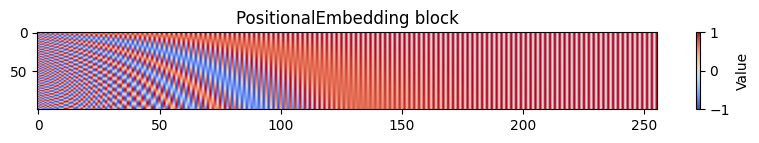

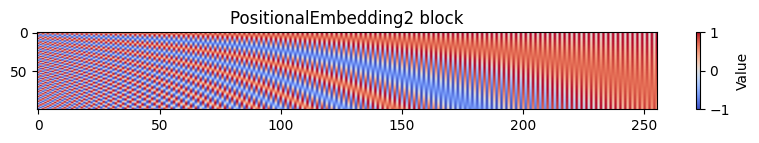

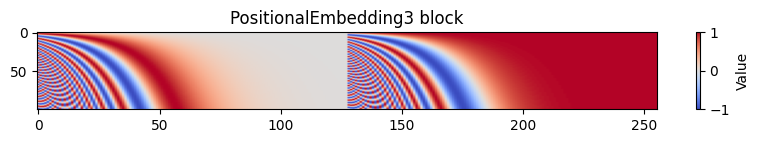

In [46]:
num_embeds = 100 # Number of vectors
embedding_dim = 256 # Vector size

semb = PositionalEmbedding(T, output_dim=embedding_dim)
semb2 = PositionalEmbedding2(T=T, time_embed_dim=embedding_dim, device=device)
semb3 = PositionalEmbedding3(embedding_dim=embedding_dim, device=device)

time_embeddings = torch.empty(num_embeds, embedding_dim)
time_embeddings2 = torch.empty(num_embeds, embedding_dim)
time_embeddings3 = torch.empty(num_embeds, embedding_dim)

for i in range(num_embeds):
    embd = semb.forward(torch.Tensor([i]).long())
    time_embeddings[i] = embd

    embd = semb2.forward(torch.Tensor([i]).long())
    time_embeddings2[i] = embd

    embd = semb3.forward(torch.Tensor([i]).long())
    time_embeddings3[i] = embd

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb.__class__.__name__} block")
# plt.axis('off')  # Optional: hide axes
plt.show()

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings2.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb2.__class__.__name__} block")
# plt.axis('off')  # Optional: hide axes
plt.show()

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings3.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb3.__class__.__name__} block")
# plt.axis('off')  # Optional: hide axes
plt.show()

# Linear, Cosine noise schedulers

In [47]:
class BaseNoiseScheduler(nn.Module, metaclass=abc.ABCMeta):
    def __init__(self, timesteps: int, device: str):
        super().__init__()
        self.timesteps = timesteps
        self.device = device

    @abc.abstractmethod
    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

    @property
    def alpha_t(self):
        return self._alpha_t

    @property
    def beta_t(self):
        return self._beta_t

    @property
    def alpha_cumprod(self):
        return self._alpha_t_cumprod

class LinearNoiseScheduler(BaseNoiseScheduler):
    def __init__(self, device: str, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__(timesteps, device)

        beta_t = torch.linspace(beta_start, beta_end, timesteps)
        alpha_t = 1.0 - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

class CosineNoiseScheduler(BaseNoiseScheduler):
    def __init__(self, device: str, timesteps: int = 1000, s: float = 0.008):
        super().__init__(timesteps, device)

        steps = timesteps + 1
        t = torch.linspace(0, timesteps, steps) / timesteps
        alpha_bar = torch.cos(((t + s) / (1 + s)) * math.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        beta_t = 1 - (alpha_bar[1:] / alpha_bar[:-1])
        beta_t = torch.clamp(beta_t, max=0.999)

        alpha_t = 1. - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

class ReducedCosineNoiseScheduler(BaseNoiseScheduler):
    """
    A modified version of the CosineNoiseScheduler that allows for a noise strength reduction.
    This scheduler adjusts the alpha_bar to prevent it from going to zero too much
    """
    def __init__(self, device: str, timesteps: int = 1000, s: float = 0.008, noise_strength_reduction: float = 0.0):
        super().__init__(timesteps, device)

        steps = timesteps + 1
        t = torch.linspace(0, timesteps, steps) / timesteps

        # Original alpha_bar calculation
        alpha_bar_original = torch.cos(((t + s) / (1 + s)) * math.pi * 0.5) ** 2
        alpha_bar_original = alpha_bar_original / alpha_bar_original[0]

        # Apply a simple linear adjustment to alpha_bar to prevent it from going to zero too much
        # This will keep alpha_bar_t slightly higher at later timesteps
        # noise_strength_reduction = 0.0 means no change (original behavior)
        # noise_strength_reduction = 1.0 means alpha_bar_t becomes 1 (no noise) for all t
        # A small value like 0.1 or 0.2 might be suitable.
        self.alpha_bar = alpha_bar_original * (1 - noise_strength_reduction) + noise_strength_reduction

        beta_t = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
        beta_t = torch.clamp(beta_t, max=0.999) # Ensure beta_t doesn't exceed 0.999

        alpha_t = 1. - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        # Ensure alpha_t_cumprod does not go below a certain threshold
        # This is a more direct way to control the minimum alpha_bar_t
        min_alpha_bar_threshold = 0.01 # Example: prevent alpha_bar from going below 0.01 (1%)
        self.alpha_t_cumprod = torch.clamp(self.alpha_t_cumprod, min=min_alpha_bar_threshold)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

# Compare noise schedulers

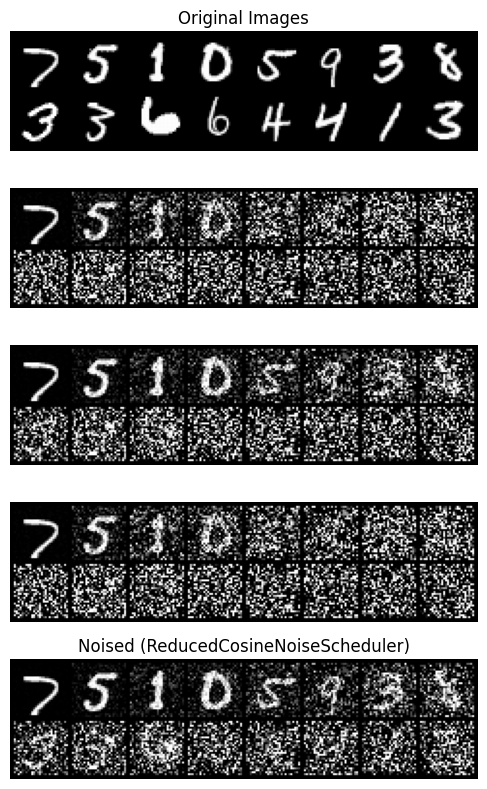

In [48]:
train_dataloader = get_mnist_loader_and_transform().train_loader
# Sample batch
x, y = next(iter(train_dataloader))  # Shape: (B, C, H, W)
x = x[:16]  # Use first 64 images for consistent layout

# Timesteps: left to right → increasing noise
t = torch.linspace(1, T - 1, 16).long()

# Generate one fixed noise tensor for fairness
noise = torch.randn_like(x)

# Linear scheduler
linear_sched = LinearNoiseScheduler(device, timesteps=T)
noised_linear = linear_sched.add_noise(x, noise, t)

# Cosine scheduler
cosine_sched = CosineNoiseScheduler(device, timesteps=T)
noised_cosine = cosine_sched.add_noise(x, noise, t)

# DDPMScheduler from diffusers
ddpm_sched = DDPMScheduler(num_train_timesteps=T, beta_schedule="linear")
alphas_cumprod = ddpm_sched.alphas_cumprod.to(x.device)
sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)
noised_ddpm = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

# Cosine scheduler 2 with noise strength reduction
cosine_sched2 = ReducedCosineNoiseScheduler(device, timesteps=T, noise_strength_reduction=0.4)
noised_cosine2 = cosine_sched2.add_noise(x, noise, t)

# Plot side-by-side
fig, axs = plt.subplots(5, 1, figsize=(30, 8))

axs[0].imshow(torchvision.utils.make_grid(x.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Images")

axs[1].imshow(torchvision.utils.make_grid(noised_linear.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({linear_sched.__class__.__name__})")

axs[2].imshow(torchvision.utils.make_grid(noised_cosine.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({cosine_sched.__class__.__name__})")

axs[3].imshow(torchvision.utils.make_grid(noised_ddpm.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({ddpm_sched.__class__.__name__})")

axs[4].imshow(torchvision.utils.make_grid(noised_cosine2.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({cosine_sched2.__class__.__name__})")

# Remove axis ticks
for i in range(5):
    axs[i].axis("off")

plt.tight_layout()
plt.show()

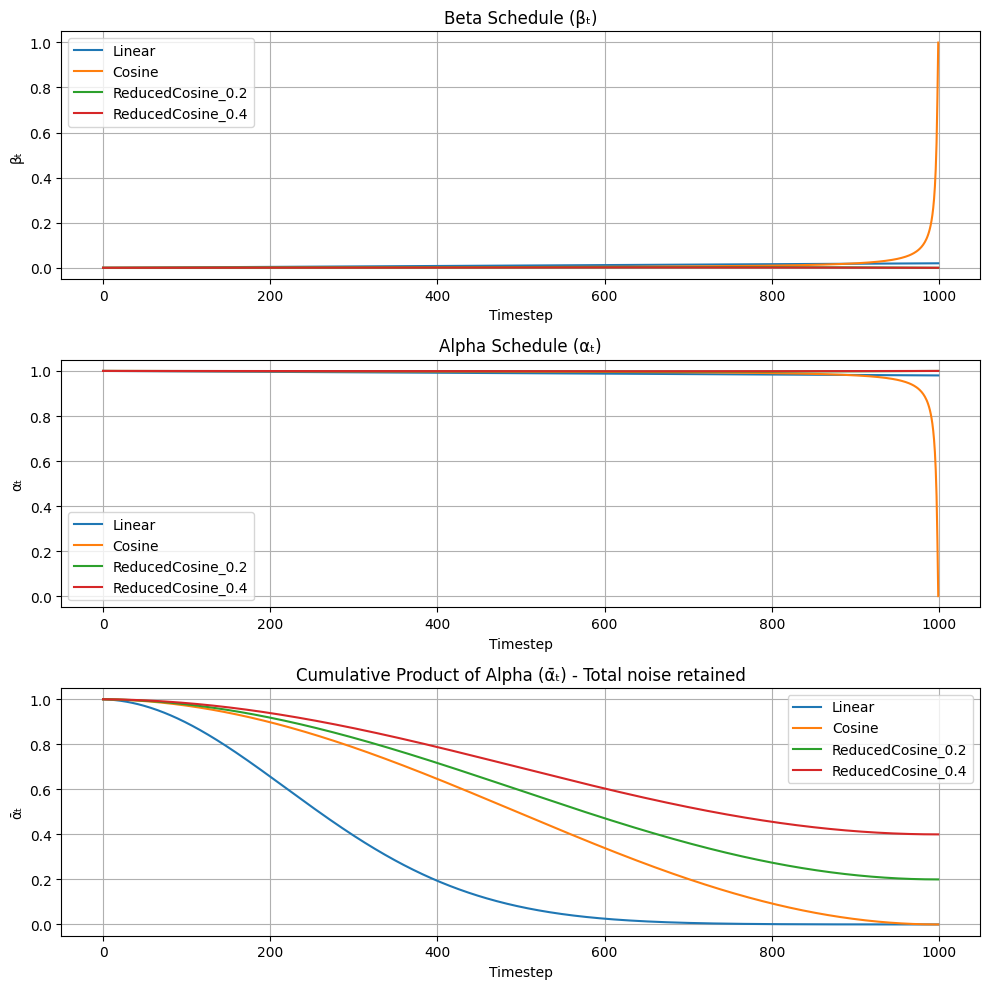

In [49]:
def plot_noise_schedulers(schedulers: dict):
    plt.figure(figsize=(10, 10))

    for i, (name, scheduler) in enumerate(schedulers.items()):
        timesteps = scheduler.timesteps
        x = list(range(timesteps))

        # Plot beta_t
        plt.subplot(3, 1, 1)
        plt.plot(x, scheduler.beta_t.cpu().numpy(), label=name)
        plt.title("Beta Schedule (βₜ)")
        plt.ylabel("βₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

        # Plot alpha_t
        plt.subplot(3, 1, 2)
        plt.plot(x, scheduler.alpha_t.cpu().numpy(), label=name)
        plt.title("Alpha Schedule (αₜ)")
        plt.ylabel("αₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

        # Plot alpha_cumprod (ᾱₜ)
        plt.subplot(3, 1, 3)
        plt.plot(x, scheduler.alpha_cumprod.cpu().numpy(), label=name)
        plt.title("Cumulative Product of Alpha (ᾱₜ) - Total noise retained")
        plt.ylabel("ᾱₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

schedulers = {
    "Linear": LinearNoiseScheduler(device=device),
    "Cosine": CosineNoiseScheduler(device=device),
    "ReducedCosine_0.2": ReducedCosineNoiseScheduler(device=device, noise_strength_reduction=0.2),
    "ReducedCosine_0.4": ReducedCosineNoiseScheduler(device=device, noise_strength_reduction=0.4),
}

plot_noise_schedulers(schedulers)

# My custom UNet

In [50]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        T: int,
        time_emb_dim: int,
        device: str
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.T = T

        self.time_embedding = TimeEmbeddingProjection(T=T, device=device, time_emb_dim=time_emb_dim, proj_scale=2)

        num_groups = 8
        hidden_channels = 256
        self.num_groups = num_groups
        self.hidden_channels = hidden_channels

        # Downsampling
        self.down1 = DownBlock(in_channels, hidden_channels, num_groups, time_emb_dim)               # skip1: 256
        self.down2 = DownBlock(hidden_channels, hidden_channels * 2, num_groups, time_emb_dim)       # skip2: 512
        self.down3 = DownBlock(hidden_channels * 2, hidden_channels * 4, num_groups, time_emb_dim)   # skip3: 1024

        # Middle bottleneck
        self.middle = MiddleBlock(hidden_channels * 4, num_groups, time_emb_dim)

        # Upsampling
        self.up1 = UpBlock(
            in_channels=hidden_channels * 4,       # x from middle
            skip_channels=hidden_channels * 4,     # skip3
            out_channels=hidden_channels * 2,
            num_groups=num_groups,
            time_emb_dim=time_emb_dim
        )
        self.up2 = UpBlock(
            in_channels=hidden_channels * 2,       # x from up1
            skip_channels=hidden_channels * 2,     # skip2
            out_channels=hidden_channels,
            num_groups=num_groups,
            time_emb_dim=time_emb_dim
        )
        self.up3 = UpBlock(
            in_channels=hidden_channels,           # x from up2
            skip_channels=hidden_channels,         # skip1
            out_channels=hidden_channels,
            num_groups=num_groups,
            time_emb_dim=time_emb_dim
        )

        # Final convolution
        self.final_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t_emb = self.time_embedding(t)

        # Downsampling
        conv1, pool1 = self.down1(x, t_emb)
        conv2, pool2 = self.down2(pool1, t_emb)
        conv3, pool3 = self.down3(pool2, t_emb)

        # Middle
        middle = self.middle(pool3, t_emb)

        # Upsampling
        u1 = self.up1(middle, conv3, t_emb)
        u2 = self.up2(u1, conv2, t_emb)
        u3 = self.up3(u2, conv1, t_emb)

        return self.final_conv(u3)


In [51]:
class DDPM(nn.Module):
    """
    My re-implementation of conditional DDPM that usess a UNet.
    The forward function is the forward diffusion process and returns the loss.
    The sample function returns images sampled from the learned distribution.
    """
    def __init__(
        self,
        T: int,
        unet: nn.Module,
        noise_scheduler: BaseNoiseScheduler,
        device: str
    ):
        super().__init__()
        self.T = T
        self.unet = unet.to(device)
        self.noise_sched = noise_scheduler.to(device)
        self.device = device

        # pre-compute sqrt(alpha_t) and sqrt(1 - alpha_t_bar) for all timesteps
        bar_alpha_t = self.noise_sched.alpha_cumprod
        sqrt_bar_alpha_t = torch.sqrt(bar_alpha_t)
        sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t)
        self.register_buffer("sqrt_bar_alpha_t", sqrt_bar_alpha_t)
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", sqrt_minus_bar_alpha_t_schedule)

        # MSE loss is ||noise - predicted_noise||^2
        # This is line 5 in the training algorithm in DDPM paper
        self.criterion = nn.MSELoss()

    def forward(self, imgs: torch.Tensor, conditionings: Optional[torch.Tensor] = None) -> torch.Tensor:
        b, c, h, w = imgs.shape

        # random choose some time steps
        t = torch.randint(low=1, high=self.T+1, size=(b,), device=self.device)

        # get random noise to add it to the images
        noise = torch.randn_like(imgs, device=self.device)

        # get noise image as: sqrt(bar_alpha_t) * x0 + sqrt(1 - bar_alpha_t) * noise
        # where x0 = imgs

        # apply noise via reshaping to 1D tensor (view batch)
        noise_imgs = self.sqrt_bar_alpha_t[t].view((b, 1, 1, 1)) * imgs + \
            self.sqrt_minus_bar_alpha_t_schedule[t].view((b, 1, 1, 1)) * noise

        # get predicted noise from our model
        pred_noise = self.unet(noise_imgs, t.unsqueeze(1))

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        return self.criterion(pred_noise, noise)

    def sample(self, n_samples, size):
        self.eval()
        with torch.no_grad():
            # get normal noise (Gaussian) as x_T (last image in diffusion process)
            x_t = torch.randn(n_samples, *size, device=self.device)

            # calculate x_(t-1) on every iteration: [T, T-1, ..., 1, 0]
            for t_index in range(self.T, 0, -1):
                # The same step is applied to all the batch, thats why we repeat t_index
                t_tensor = torch.tensor([t_index], device=self.device).repeat(x_t.shape[0], 1)

                # get predicted noise from model
                pred_noise = self.unet(x_t, t_tensor)

                # get some noise to calculate x_(t-1) as in formula (How to get a Noise)
                # for t = 0, noise should be 0
                # This is line 3 in the Sampling algorithm in DDPM paper
                z = torch.randn_like(x_t, device=self.device) if t_index > 0 else 0

                # Line 4 in the Sampling algorithm in DDPM paper
                x_t = 1 / torch.sqrt(self.noise_sched.alpha_t[t_index]) * \
                    (x_t - pred_noise * (1 - self.noise_sched.alpha_t[t_index]) / self.sqrt_minus_bar_alpha_t_schedule[t_index]) + \
                    torch.sqrt(self.noise_sched.beta_t[t_index]) * z

            # We reached t = 0, so we return x_0 (the samples)
            return x_t

In [52]:
batch_size = 64
data = get_mnist_loader_and_transform(batch_size=batch_size)

ddpm = DDPM(
    T = T,
    unet=UNet(
        in_channels=data.in_channels,
        out_channels=data.out_channels,
        T=T+1,
        time_emb_dim=128,
        device=device
    ),
    noise_scheduler=CosineNoiseScheduler(device=device, timesteps=T+1),
    device=device
)

data

DataPack(train_dataset=Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: ToTensor(), train_loader=<torch.utils.data.dataloader.DataLoader object at 0x00000267C38A1B90>, val_dataset=Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets
    Split: Test
    StandardTransform
Transform: ToTensor(), val_loader=<torch.utils.data.dataloader.DataLoader object at 0x00000267C3718C10>, transform_to_tensor=ToTensor(), transform_to_pil=<__main__.MNISTTransformation object at 0x00000267E95FDBD0>, in_channels=1, out_channels=1, num_classes=10, recommended_steps=(1, 2, 4), recommended_attn_step_indexes=[1])

In [53]:
num_of_params = sum([p.numel() for p in ddpm.parameters()])

print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# summary(ddpm, input_size=(1, 1, 32, 32))  # adjust input size to your model
def count_params(model):
    lst = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            lst.append((name, param))
            # print(f"{name}: {param.numel()} parameters")
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total}")
    return lst

lst = count_params(ddpm)
lst_sorted = sorted(lst, key=lambda x: x[1].numel(), reverse=True)
for name, param in lst_sorted:
    print(f"{name:<60} {param.numel():,} parameters")

Number of trainable parameters in the model: 74,981,505

Total Trainable Parameters: 74981505
unet.down3.resblock.conv2.0.weight                           9,437,184 parameters
unet.middle.resblock1.conv1.0.weight                         9,437,184 parameters
unet.middle.resblock1.conv2.0.weight                         9,437,184 parameters
unet.middle.resblock2.conv1.0.weight                         9,437,184 parameters
unet.middle.resblock2.conv2.0.weight                         9,437,184 parameters
unet.up1.resblock.conv1.0.weight                             7,077,888 parameters
unet.down3.resblock.conv1.0.weight                           4,718,592 parameters
unet.down2.resblock.conv2.0.weight                           2,359,296 parameters
unet.up1.resblock.conv2.0.weight                             2,359,296 parameters
unet.up1.up.weight                                           2,097,152 parameters
unet.up2.resblock.conv1.0.weight                             1,769,472 parameters
unet

In [54]:
def show_samples():
    samples = ddpm.sample(32, size=(1, 32, 32))
    grid = torchvision.utils.make_grid(samples)
    plt.figure(figsize=(8, 8))
    plt.imshow(data.transform_to_pil(grid).clip(0, 1))
    plt.axis('off')
    plt.title("Generated Samples")
    plt.show()

In [55]:
def train(
    model: DDPM,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader
):
    training_losses = []
    val_losses = []
    for epoch in range(epochs):
        show_samples()

        model.train(True)
        training_loss = 0
        val_loss = 0
        pbar = tqdm.tqdm(train_dataloader)
        for index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()

            imgs = imgs.to(device)

            loss = model(imgs)

            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            pbar.set_description(f"loss for epoch {epoch}: {training_loss / (index + 1):.4f}")
        model.eval()
        with torch.no_grad():
            for (imgs, labels) in val_dataloader:
                imgs = imgs.to(device)

                loss = model(imgs)

                val_loss += loss.item()
        training_losses.append(training_loss / len(val_dataloader))
        val_losses.append(val_loss / len(val_dataloader))

        show_samples()
    return training_losses, val_losses

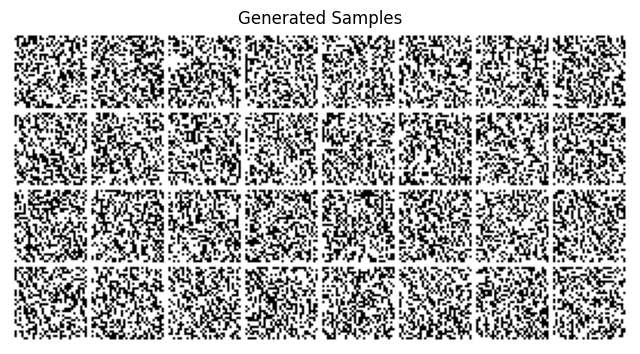

loss for epoch 0: 0.0616: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


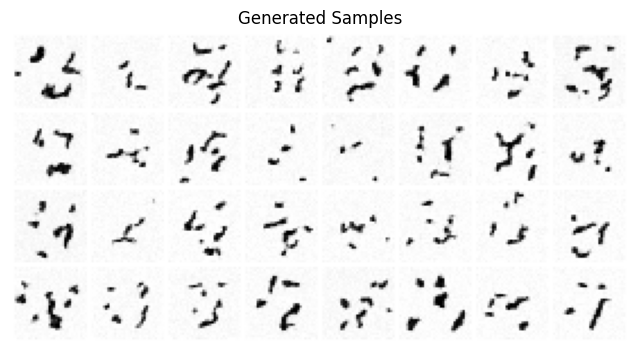

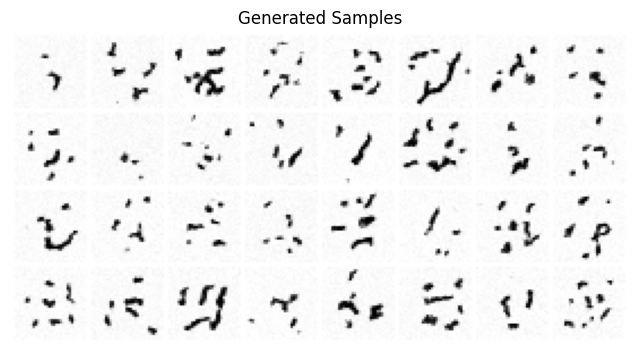

loss for epoch 1: 0.0336: 100%|██████████| 938/938 [02:57<00:00,  5.30it/s]


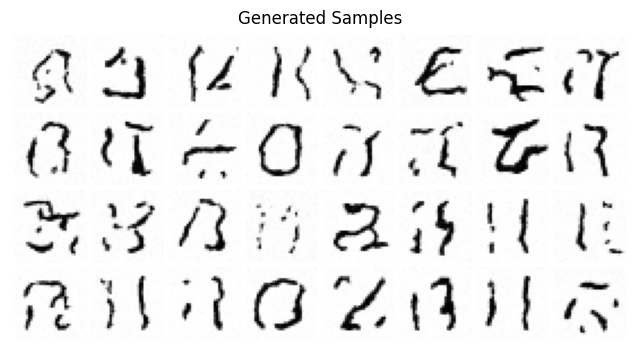

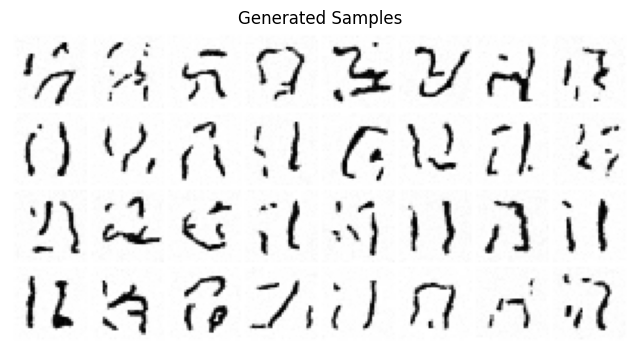

loss for epoch 2: 0.0298: 100%|██████████| 938/938 [03:15<00:00,  4.79it/s]


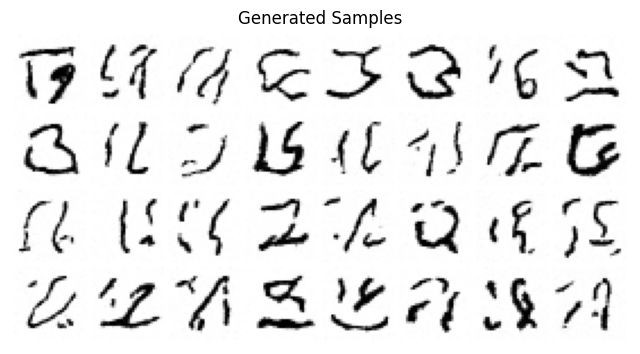

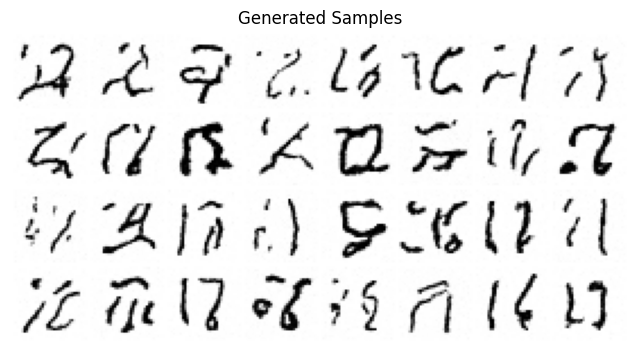

loss for epoch 3: 0.0286: 100%|██████████| 938/938 [03:20<00:00,  4.67it/s]


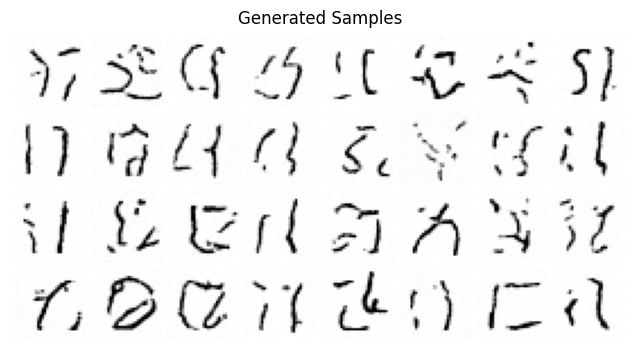

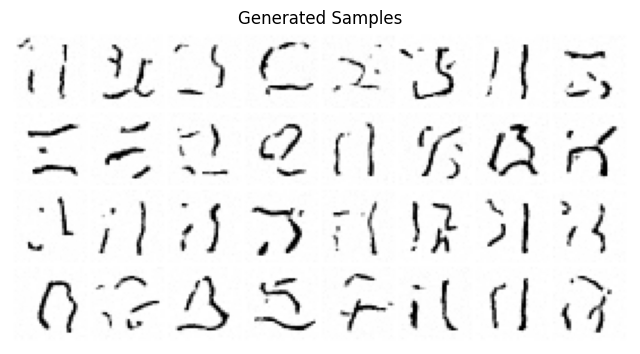

loss for epoch 4: 0.0278: 100%|██████████| 938/938 [02:56<00:00,  5.32it/s]


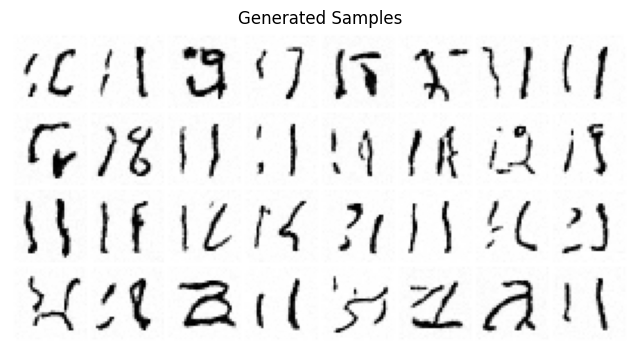

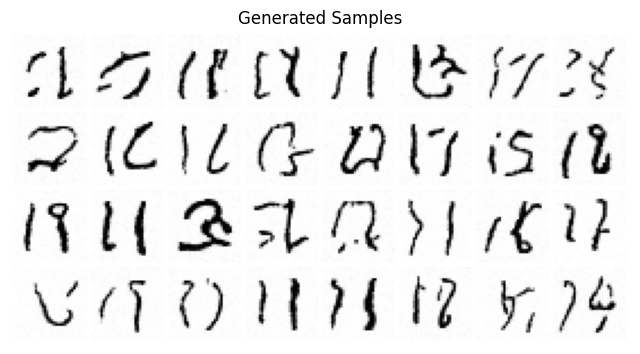

loss for epoch 5: 0.0273: 100%|██████████| 938/938 [03:06<00:00,  5.03it/s]


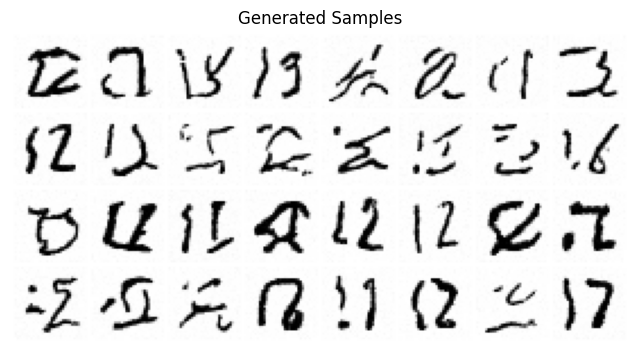

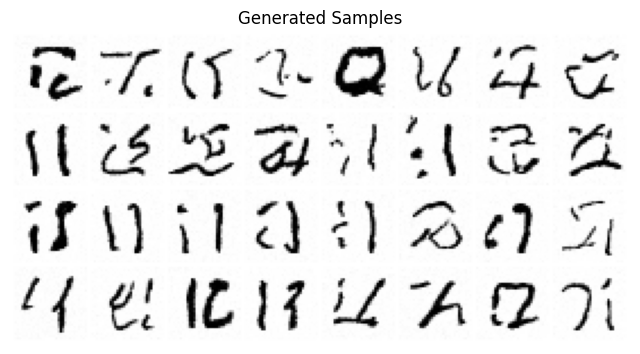

loss for epoch 6: 0.0268: 100%|██████████| 938/938 [03:11<00:00,  4.90it/s]


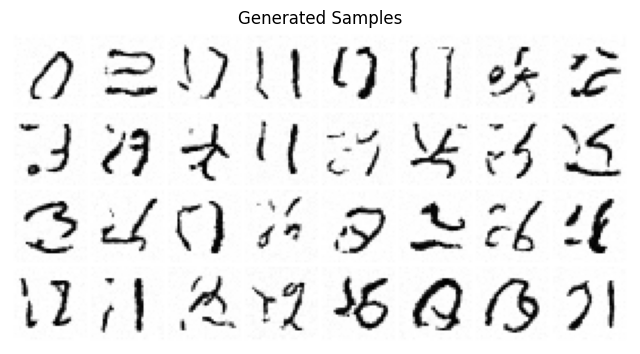

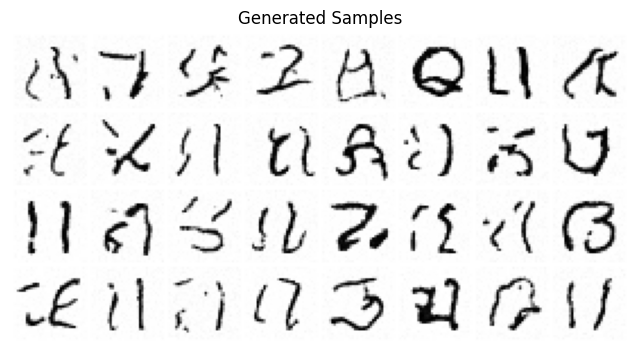

loss for epoch 7: 0.0267: 100%|██████████| 938/938 [03:05<00:00,  5.06it/s]


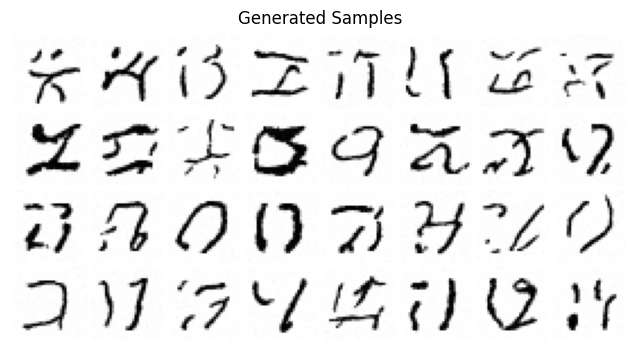

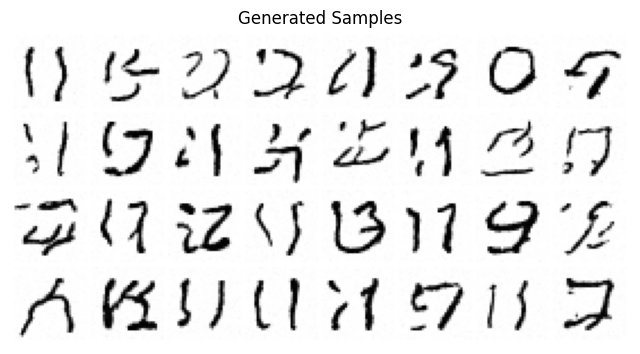

loss for epoch 8: 0.0265: 100%|██████████| 938/938 [03:06<00:00,  5.03it/s]


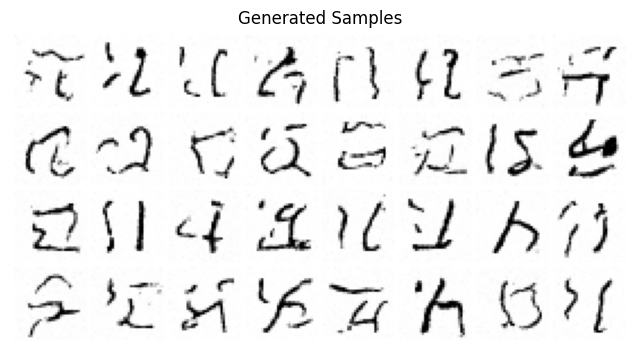

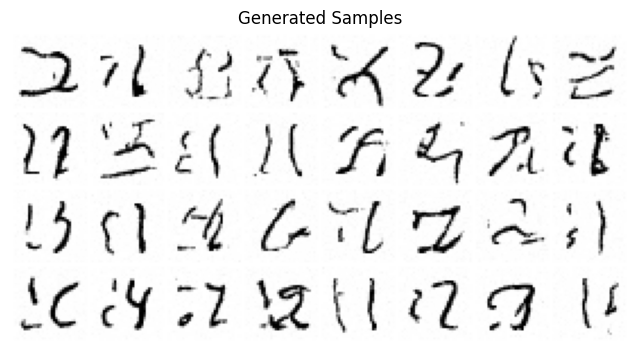

loss for epoch 9: 0.0263: 100%|██████████| 938/938 [03:17<00:00,  4.75it/s]


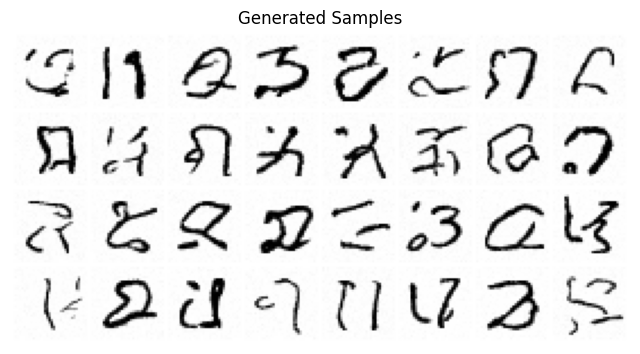

([0.36775120265876793,
  0.2008529169378197,
  0.17792835409284397,
  0.17074512718779267,
  0.1662281493116526,
  0.16328161513539635,
  0.1602316312966453,
  0.15933614873155288,
  0.15827765908376995,
  0.15705748723380886],
 [0.038428868267946184,
  0.030008991326021542,
  0.028911905220834314,
  0.028074239339133736,
  0.027228618645743958,
  0.026913297985484644,
  0.026700815055400704,
  0.026576982692453514,
  0.02635464728305674,
  0.02549905573154331])

In [56]:
train(
    model=ddpm,
    optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
    epochs=10,
    device=device,
    train_dataloader=data.train_loader,
    val_dataloader=data.val_loader
)

In [57]:
# _, val_losses = train(
#     model=ddpm,
#     optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
#     epochs=EPOCHS,
#     device=device,
#     train_dataloader=data.train_loader,
#     val_dataloader=data.val_loader
# )

# plt.plot(val_losses, label="Validation Loss")

# plt.legend()

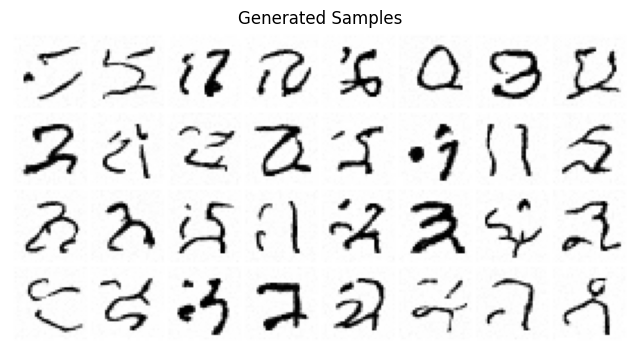

In [58]:
show_samples()

In [59]:
torch.save(ddpm.state_dict(), 'train1.pth')